In [246]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [247]:
words = open('names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [248]:
len(words)

32033

In [249]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s: i+1 for i, s in enumerate(chars)}
stoi['.'] = 0
itos = {i: s for s, i in stoi.items()}
print(itos)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [ ]:
# build the dataset
blocksize = 3 # context length: how many characters do we take to predict the next one
X, Y = [], []
# for debugging
# for w in words[:5]:
for w in words:
    context = [0] * blocksize  # index of '.' characters
    for ch in w + '.':
        ix = stoi[ch]
        X.append(context)
        Y.append(ix)
        # slide the window, by popping and appending
        # print(''.join(itos[i] for i in context), '----->', itos[ix])
        context = context[1:] + [ix]

X = torch.tensor(X)
Y = torch.tensor(Y)

In [251]:
# Datasest
X.shape, Y.dtype, Y.shape, Y.dtype

(torch.Size([228146, 3]), torch.int64, torch.Size([228146]), torch.int64)

In [252]:
# Define nn parameters
g = torch.Generator().manual_seed(2147483647)

def init_nn(hidden_dim=100, emb_dim=2):
    global C, W1, b1, W2, b2, parameters
    C = torch.randn((27, emb_dim), generator=g)
    W1 = torch.randn((blocksize * emb_dim, hidden_dim), generator=g)
    b1 = torch.randn(hidden_dim, generator=g)
    W2 = torch.randn((hidden_dim, 27), generator=g)
    b2 = torch.randn(27, generator=g)
    parameters = [C, W1, b1, W2, b2]

# Long form
g = torch.Generator().manual_seed(2147483647)
emb_dim = 2
hidden_dim = 100

# Lets create embedding (lookup table) for 27 characters into 2 dimensions
C = torch.randn((27, emb_dim), generator=g)

# Let us create hidden layer
# input layer has blocksize * 2 neurons (2 is embedding dimension)
W1 = torch.randn((blocksize * emb_dim, hidden_dim), generator=g)
b1 = torch.randn(hidden_dim, generator=g)

# Create output layer 
W2 = torch.randn((hidden_dim, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]

In [253]:
# Some playing around and manual operations

# Get an example embedding - use indexing as much faster
C[5]

# or alternatively via one-hot encoding
# F.one_hot(torch.tensor([5]), num_classes=27).float() @ C

# Lookup all the embeddings for a batch of inputs
emb_dim = 2
emb = C[X]  # (num examples, blocksize, 2)
emb.shape

# For instance, embedding of example 13, character 2 in the context
emb[13, emb_dim, :]

# To do inference, we need to first reshape the embedding from 2, 3 to 6

# Direct approach
# torch.cat([emb[:,0,:], emb[:,1,:], emb[:,2,:]], dim=1).shape

# General approach
# torch.cat(torch.unbind(emb, dim=1), dim=1).shape

# Most efficient, use in-place reshape with vieww
emb_flat = emb.view(emb.shape[0], blocksize * emb_dim)

# Example Inference - each of the examples embedded in hidden dimension space
# Verify broadcasting of b1
# hidden: num_examples, hidden_dim
#     b1:               hidden_dim
h = torch.tanh(emb.view(emb.shape[0], -1) @ W1 + b1)

logits = h @ W2 + b2
logits.shape

# Get output probabilities 
# counts = logits.exp()
# probs = counts / counts.sum(dim=1, keepdim=True)

# Easier way:
probs = torch.softmax(logits, dim=1)
probs.shape

# Determine loss based on true labels Y

# For lookup combine arrange with indices in Y
Y_probs = probs[torch.arange(probs.shape[0]), Y]
Y_probs.shape

# Determine nll loss
nll = -Y_probs.log().mean()
nll

tensor(19.5052)

In [254]:
# Number of parameters
sum(p.nelement() for p in parameters)

3481

In [255]:
# Streamlined usage of nn
emb = C[X]  # via lookup
h = torch.tanh(emb.view(emb.shape[0], -1) @ W1 + b1)  # size num_examples, hidden_dim
logits = h @ W2 + b2  # size num_examples, num_chars (27)
# probs = torch.softmax(logits, dim=1)
# nll = -(probs[torch.arange(emb.shape[0]), Y]).log().mean()
# Better to use F.cross_entropy
# - without intermediate tensors, more efficient by fused kernels and expressions can be simplified for faster bp
# - numerically more stable
nll = F.cross_entropy(logits, Y)  
nll


tensor(19.5052)

In [256]:
# Show numerical stability of F.cross_entropy
logits = torch.tensor([-100, -3, 0, 100])
counts = logits.exp() # Problem: large value exp(100) will cause overflow to inf
probs = counts / counts.sum()
probs

# Instead cross_entropy makes this stable by converting logits to probabilities in a numerically stable way by substracting largest values
logits = logits - logits.max()
counts = logits.exp()
probs = counts / counts.sum()
probs

tensor([0.0000e+00, 1.4013e-45, 3.7835e-44, 1.0000e+00])

In [257]:
# Optimize over lr
lre = torch.linspace(-3, 0, 1000)
lrs = 10**lre
lrs_losses = []

In [258]:
# Train nn
# lr strategy after tuning: 30k iteration with 0.1 lr, then manual decay to 0.01 for another 20k becaused plateuing
# gives us overall loss of 2.33 versus 2.48 for bigram lm
lr = 0.01
train_iter = 10000

for p in parameters:
    p.requires_grad = True

# for l in range(lrs.shape[0]):
#     init_nn()
#     lr = lrs[l]
for i in range(train_iter):

    # minibatch construct - smaller, hence faster training with lower quality gradient 
    # often many small imperfect steps better than few perfect steps
    # Full: ix = torch.arange(X.shape[0])
    ix = torch.randint(0, X.shape[0], (32,))
    
    # forward pass
    emb = C[X[ix]]  # via lookup
    h = torch.tanh(emb.view(emb.shape[0], -1) @ W1 + b1)  # size num_examples, hidden_dim
    logits = h @ W2 + b2  # size num_examples, num_chars (27)
    nll = F.cross_entropy(logits, Y[ix])  
    # print(f"Current loss {nll:.2f}")

    # backward pass
    for p in parameters:
        p.grad = None
    nll.backward() 
    # update
    for p in parameters:
        p.data += -lr * p.grad

print(f"Final training batch loss: {nll:.2f}")
# Cannot get to zero since ... -> x maps to different starting characters

emb = C[X]  # via lookup
h = torch.tanh(emb.view(emb.shape[0], -1) @ W1 + b1)  # size num_examples, hidden_dim
logits = h @ W2 + b2  # size num_examples, num_chars (27)
nll = F.cross_entropy(logits, Y)  
print(f"Final full training loss: {nll:.2f}")

# Tune lr
# lrs_losses.append(nll.item())

Final training batch loss: 2.53
Final full training loss: 2.57


ValueError: x and y must have same first dimension, but have shapes (1000,) and (0,)

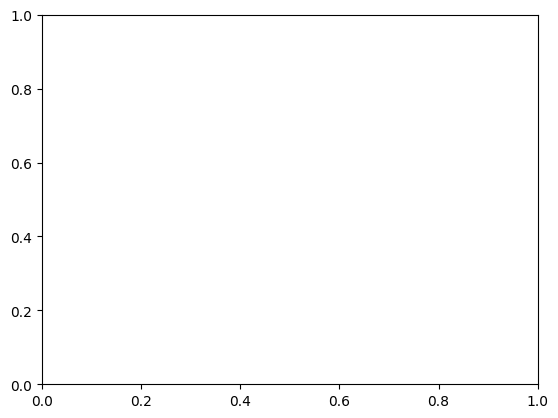

In [269]:
# Tune for 1000 learning reate -> valley actuakky for exp of -1
plt.plot(lre, lrs_losses)
plt.xlabel('log10(lr)')
plt.ylabel('Final NLL loss')
plt.title('Learning Rate Tuning')

In [ ]:
# Use train, validation, test splits
# Problem: large model will lead to loss close to zero but just by memorizing training data

In [ ]:
# build the dataset
blocksize = 3 # context length: how many characters do we take to predict the next one
splits = [0.8, 0.1, 0.1]

def build_dataset(words):
    X, Y = [], []
    for w in words:
        context = [0] * blocksize  # index of '.' characters
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix]
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    return X, Y

import random
random.seed(42)
random.shuffle(words)
split1, split2 = int(splits[0]*len(words)), int((splits[0]+splits[1])*len(words))
X_train, Y_train = build_dataset(words[:split1])
X_val, Y_val = build_dataset(words[split1:split2])
X_test, Y_test = build_dataset(words[split2:])

X_train.shape, X_val.shape, X_test.shape
Y_train.shape, Y_val.shape, Y_test.shape

(torch.Size([182437]), torch.Size([22781]), torch.Size([22928]))

In [ ]:
def compute_loss(X, Y):
    emb = C[X]  # via lookup
    h = torch.tanh(emb.view(emb.shape[0], -1) @ W1 + b1)  # size num_examples, hidden_dim
    logits = h @ W2 + b2  # size num_examples, num_chars (27)
    nll = F.cross_entropy(logits, Y)  
    return nll

In [ ]:
# initialize nn parameters
init_nn(hidden_dim=300)
sum(p.nelement() for p in parameters)

10281

In [ ]:
# train nn with splits
lr = 0.01
train_iter = 30000
loss_i = []

for p in parameters:
    p.requires_grad = True

for i in range(train_iter):
    ix = torch.randint(0, X_train.shape[0], (32,))
    
    # forward pass
    emb = C[X_train[ix]]  # via lookup
    h = torch.tanh(emb.view(emb.shape[0], -1) @ W1 + b1)  # size num_examples, hidden_dim
    logits = h @ W2 + b2  # size num_examples, num_chars (27)
    nll = F.cross_entropy(logits, Y_train[ix])  
    # print(f"Current loss {nll:.2f}")

    # backward pass
    for p in parameters:
        p.grad = None
    nll.backward() 
    # update
    for p in parameters:
        p.data += -lr * p.grad

    loss_i.append(nll.item())

print(f"Final training batch loss: {nll:.2f}")

Final training batch loss: 2.26


In [ ]:
# Evaluate on validation set
val_loss = compute_loss(X_val, Y_val)
print(f"Final validation loss: {val_loss:.2f}")
# Evaluate on test set
test_loss = compute_loss(X_test, Y_test)
print(f"Final test loss: {test_loss:.2f}")

Final validation loss: 2.26
Final test loss: 2.25


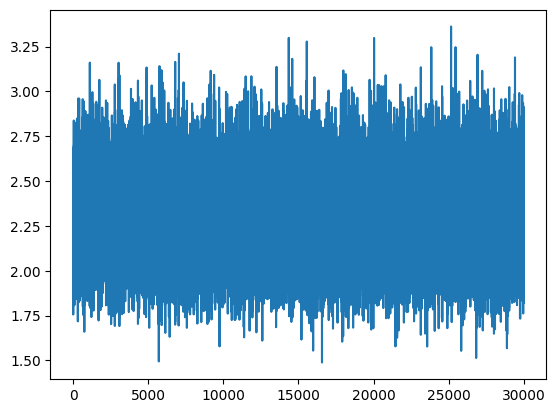

In [ ]:
# plot loss
plt.plot(range(len(loss_i)), loss_i)

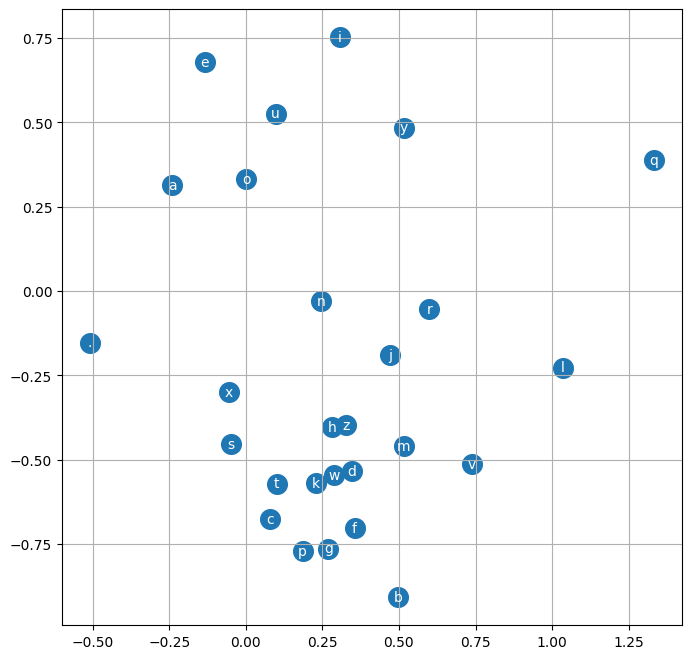

In [ ]:
# Visualize 2D character embeddings
plt.figure(figsize=(8,8))
plt.scatter(C[:,0].data, C[:,1].data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i,0].data, C[i,1].data, itos[i], ha='center', va='center', color='white')
plt.grid('minor')

In [ ]:
# Now test larger embedding dimension
init_nn(hidden_dim=200, emb_dim=10)
sum(p.nelement() for p in parameters)

11897

In [245]:
# train nn with splits, larger embedding dimension, and automatic lr
lr = 0.1
train_iter = 200000
log_loss_i = []
log_val_loss_i = []

for p in parameters:
    p.requires_grad = True

for i in range(train_iter):
    ix = torch.randint(0, X_train.shape[0], (32,))
    
    # forward pass
    emb = C[X_train[ix]]  # via lookup
    h = torch.tanh(emb.view(emb.shape[0], -1) @ W1 + b1)  # size num_examples, hidden_dim
    logits = h @ W2 + b2  # size num_examples, num_chars (27)
    nll = F.cross_entropy(logits, Y_train[ix])  
    # print(f"Current loss {nll:.2f}")

    # backward pass
    for p in parameters:
        p.grad = None
    nll.backward() 
    # update
    lr = 0.1 if i < 100000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad

    if i % 10 == 0:
        log_loss_i.append(nll.log10().item())
        val_nll = compute_loss(X_val, Y_val)
        log_val_loss_i.append(val_nll.log10().item())

print(f"Final training batch loss: {nll:.2f}")

Final training batch loss: 2.08


In [261]:
# Evaluate on validation set
val_loss = compute_loss(X_val, Y_val)
print(f"Final validation loss: {val_loss:.2f}")
# Evaluate on test set
test_loss = compute_loss(X_test, Y_test)
print(f"Final test loss: {test_loss:.2f}")

Final validation loss: 2.58
Final test loss: 2.57


In [267]:
# Smoothen the loss plots by taking average across windows of 10
def smoothen(losses, window_size=10):
    return [sum(losses[i-window_size:i])/window_size for i in range(window_size, len(losses)+1)]
smoothed_log_loss = smoothen(log_loss_i, window_size=200)
smoothed_log_val_loss = smoothen(log_val_loss_i, window_size=10)


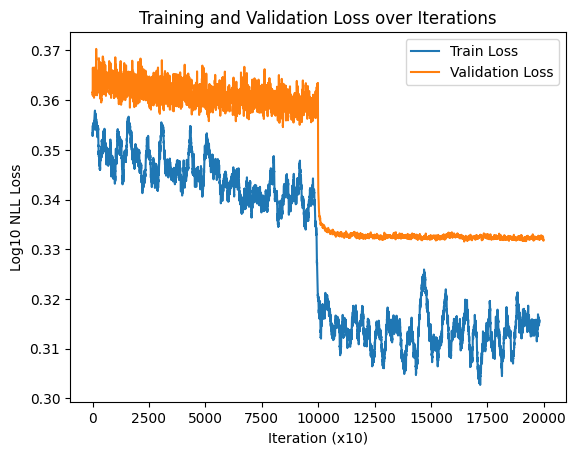

In [268]:
# Put smoothed plots into one plot and multiple x by 10 because only measure at every 10 iterations
plt.plot(range(len(smoothed_log_loss)), smoothed_log_loss, label='Train Loss')
plt.plot(range(len(smoothed_log_val_loss)), smoothed_log_val_loss, label='Validation Loss')
plt.xlabel('Iteration (x10)')
plt.ylabel('Log10 NLL Loss')
plt.title('Training and Validation Loss over Iterations')
plt.legend()

In [308]:
# Final task: beat validation loss of 2.19
init_nn(hidden_dim=200, emb_dim=10)
sum(p.nelement() for p in parameters)

11897

0.9999823390980671
Final training batch loss: 1.84
Final validation loss: 2.18


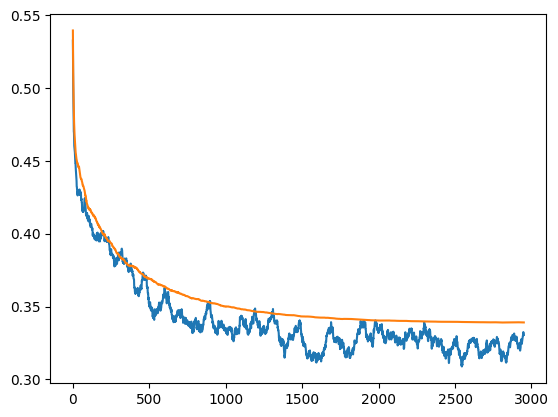

In [309]:
# train nn with splits, larger embedding dimension, and automatic lr
lr = 0.2
min_lr = 0.001
train_iter = 300000
lr_decay = (min_lr/lr)**(1/train_iter)
print(lr_decay)
log_loss_i = []
log_val_loss_i = []

for p in parameters:
    p.requires_grad = True

for i in range(train_iter):
    ix = torch.randint(0, X_train.shape[0], (32,))
    
    # forward pass
    emb = C[X_train[ix]]  # via lookup
    h = torch.tanh(emb.view(emb.shape[0], -1) @ W1 + b1)  # size num_examples, hidden_dim
    logits = h @ W2 + b2  # size num_examples, num_chars (27)
    nll = F.cross_entropy(logits, Y_train[ix])  
    # print(f"Current loss {nll:.2f}")

    # backward pass
    for p in parameters:
        p.grad = None
    nll.backward() 
    # add lr decay dynamically over iterations
    lr *= lr_decay
    for p in parameters:
        p.data += -lr * p.grad

    if i % 100 == 0:
        log_loss_i.append(nll.log10().item())
        val_nll = compute_loss(X_val, Y_val)
        log_val_loss_i.append(val_nll.log10().item())

print(f"Final training batch loss: {nll:.2f}")
print(f"Final validation loss: {compute_loss(X_val, Y_val):.2f}")

# print smoothened loss curves
smoothed_log_loss = smoothen(log_loss_i, window_size=50)
smoothed_log_val_loss = smoothen(log_val_loss_i, window_size=50)
plt.plot(range(len(smoothed_log_loss)), smoothed_log_loss, label='Train Loss')
plt.plot(range(len(smoothed_log_val_loss)), smoothed_log_val_loss, label='Validation Loss')

In [311]:
# Sample from final model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
    out = []
    context = [0] * 3
    while True:
        emb = C[torch.tensor([context])]
        h = torch.tanh(emb.view(1, -1) @ W1 + b1)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim=1)
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        context = context[1:] + [ix]
        out.append(ix)
        if ix == 0:
            break
        
    print(''.join(itos[i] for i in out))

carpaveah.
jhlarik.
milia.
aty.
skanden.
jazhita.
den.
art.
kaqui.
ner.
kia.
chaiiv.
kaleigph.
brooklyn.
sint.
shon.
wayviani.
wajell.
dearyn.
kar.
